In [2]:
import datetime as dt
# import holidays       
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_csv("MRFST.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10-10-2018,61521.00000,64300.00000,61521.00000,63979.60156,63528.64844,6132
1,11-10-2018,62990.00000,64269.64844,61709.05078,63427.50000,62980.43359,6805
2,12-10-2018,63620.00000,64959.94922,63620.00000,63978.35156,63527.40625,11121
3,15-10-2018,63625.19922,64579.85156,62000.00000,62600.60156,62159.36719,12243
4,16-10-2018,62991.85156,63980.00000,62862.14844,63212.94922,62767.38672,6090


In [5]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

In [6]:
df.set_index(["Date"],inplace=True)

In [7]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-10,61521.00000,64300.00000,61521.00000,63979.60156,63528.64844,6132
2018-10-11,62990.00000,64269.64844,61709.05078,63427.50000,62980.43359,6805
2018-10-12,63620.00000,64959.94922,63620.00000,63978.35156,63527.40625,11121
2018-10-15,63625.19922,64579.85156,62000.00000,62600.60156,62159.36719,12243
2018-10-16,62991.85156,63980.00000,62862.14844,63212.94922,62767.38672,6090


In [8]:
dfclose = df.iloc[:,3:4]

In [9]:
dfclose.head()

,Close
Date,
2018-10-10,63979.60156
2018-10-11,63427.50000
2018-10-12,63978.35156
2018-10-15,62600.60156
2018-10-16,63212.94922


In [10]:
dfclose.dropna(inplace=True)
dfclose.head()

,Close
Date,
2018-10-10,63979.60156
2018-10-11,63427.50000
2018-10-12,63978.35156
2018-10-15,62600.60156
2018-10-16,63212.94922


In [11]:
#Now we will plot the mean temperatures 

<Axes: xlabel='Date'>

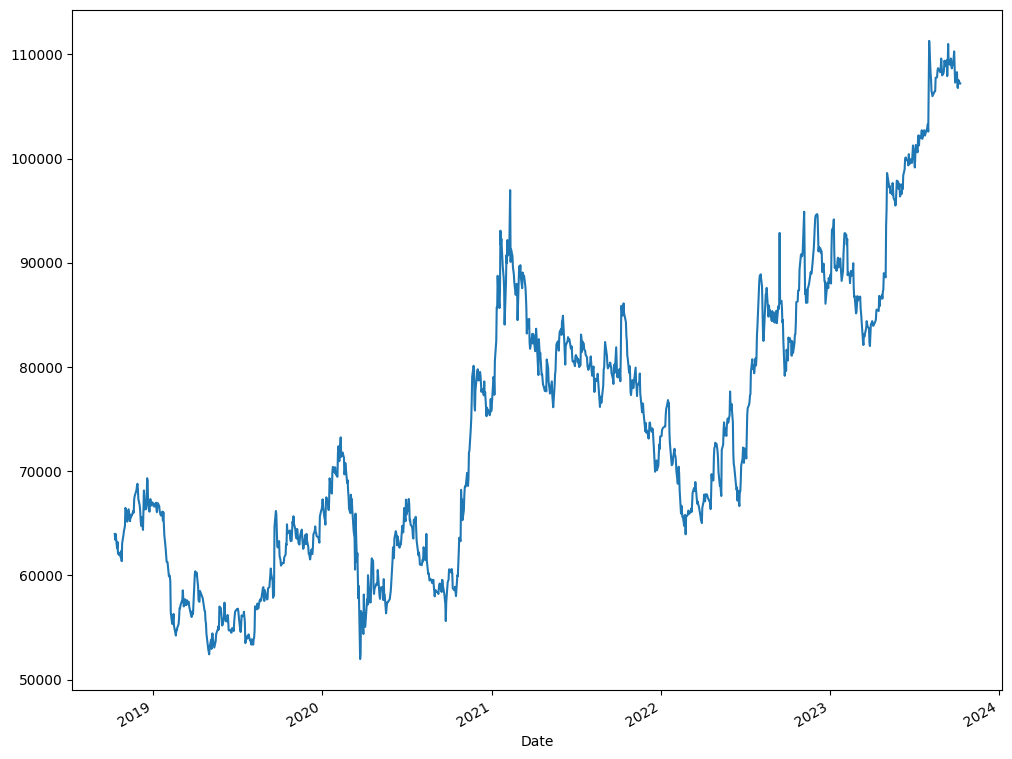

In [12]:
dfclose['Close'].plot(figsize=(12, 10))

In [13]:
#Here we can see seasonality and trend

In [14]:
#performing the rolling statistics test
dfclose['rollMean'] = dfclose.Close.rolling(window=12).mean()    
dfclose['rollStd'] = dfclose.Close.rolling(window=12).std() 

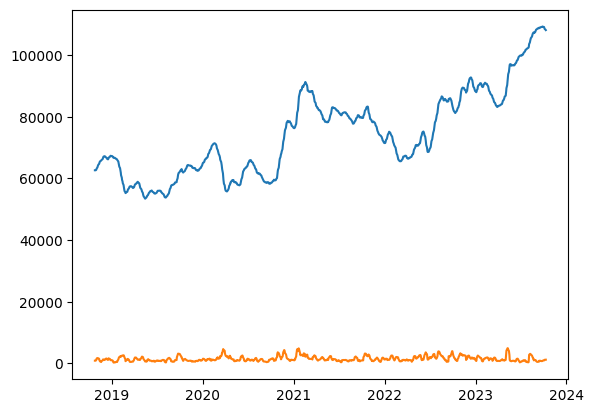

In [15]:
plt.plot(dfclose.rollMean)
plt.plot(dfclose.rollStd);

In [16]:
# seasonal_decompose(dfclose['Close']).plot() # error here proves theres no seasonality I THINK; Edit: That seems to be the case...
# Read the first answer: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
#Here we can see that the data has a lot of spikes so lets do the adfuller test to see if stationarity has beeen achieved

In [17]:
def test_stationarity(df, var):
    df['rollMean'] = df[var].rolling(window=12).mean()    # rolling on 12 months
    df['rollStd'] = df[var].rolling(window=12).std()
    
    
    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(df[var],autolag='AIC')
    stats = pd.Series(adfTest[0:4],index =['Test Statistics','p-value','#lags used', 'number of observations used'])
    print(stats)
    
    for key, values in adfTest[4].items():    
        print('crticality',key,":",values)
    
    plt.plot(df[var])
    plt.plot(df.rollMean)
    plt.plot(df.rollStd)

Test Statistics                  -0.571284
p-value                           0.877340
#lags used                        1.000000
number of observations used    1234.000000
dtype: float64
crticality 1% : -3.435660336370594
crticality 5% : -2.863885022214541
crticality 10% : -2.568018522153254


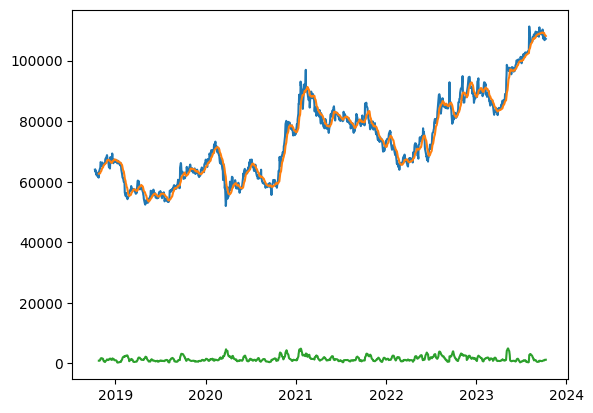

In [18]:
test_stationarity(dfclose,"Close")

In [19]:
#thus the p-value is not less than 0.05, hence the data is not stationary, we go for log transformations

In [20]:
dfclose["log"] = np.log(dfclose["Close"])

In [21]:
dfclose.head()

,Close,rollMean,rollStd,log
Date,,,,
2018-10-10,63979.60156,NaN,NaN,11.066320
2018-10-11,63427.50000,NaN,NaN,11.057653
2018-10-12,63978.35156,NaN,NaN,11.066300
2018-10-15,62600.60156,NaN,NaN,11.044530
2018-10-16,63212.94922,NaN,NaN,11.054264


Test Statistics                  -0.776924
p-value                           0.825807
#lags used                        6.000000
number of observations used    1229.000000
dtype: float64
crticality 1% : -3.4356819860439574
crticality 5% : -2.863894574114006
crticality 10% : -2.568023609111511


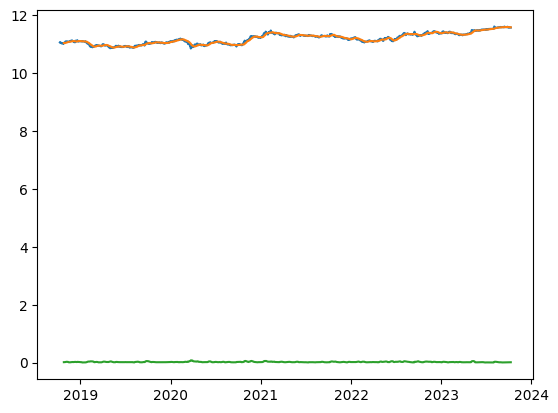

In [22]:
test_stationarity(dfclose,"log")

In [23]:
dfclose['shift'] = dfclose.Close.shift(1) 
dfclose['shiftDiff'] = dfclose.Close - dfclose['shift']
dfclose.head()

,Close,rollMean,rollStd,log,shift,shiftDiff
Date,,,,,,
2018-10-10,63979.60156,NaN,NaN,11.066320,NaN,NaN
2018-10-11,63427.50000,NaN,NaN,11.057653,63979.60156,-552.10156
2018-10-12,63978.35156,NaN,NaN,11.066300,63427.50000,550.85156
2018-10-15,62600.60156,NaN,NaN,11.044530,63978.35156,-1377.75000
2018-10-16,63212.94922,NaN,NaN,11.054264,62600.60156,612.34766


C:\Users\Kavita manoj\AppData\Local\Temp\ipykernel_24844\2575951211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rollMean'] = df[var].rolling(window=12).mean()    # rolling on 12 months
C:\Users\Kavita manoj\AppData\Local\Temp\ipykernel_24844\2575951211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rollStd'] = df[var].rolling(window=12).std()


Test Statistics                  -0.583883
p-value                           0.874582
#lags used                        1.000000
number of observations used    1223.000000
dtype: float64
crticality 1% : -3.4357081998138064
crticality 5% : -2.863906139614306
crticality 10% : -2.568029768447359


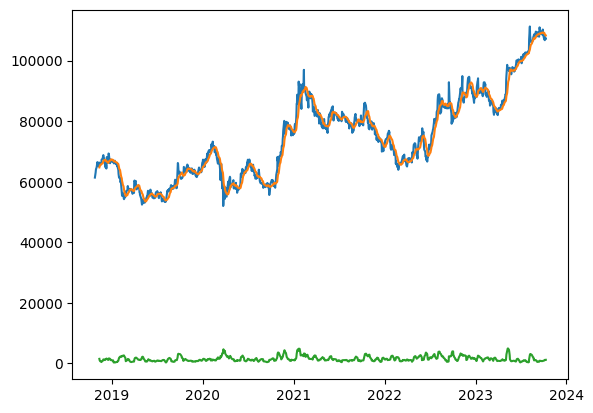

In [24]:
test_stationarity(dfclose.dropna(),"shift")

C:\Users\Kavita manoj\AppData\Local\Temp\ipykernel_24844\2575951211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rollMean'] = df[var].rolling(window=12).mean()    # rolling on 12 months
C:\Users\Kavita manoj\AppData\Local\Temp\ipykernel_24844\2575951211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rollStd'] = df[var].rolling(window=12).std()


Test Statistics                 -37.831073
p-value                           0.000000
#lags used                        0.000000
number of observations used    1224.000000
dtype: float64
crticality 1% : -3.4357038129673962
crticality 5% : -2.8639042041471887
crticality 10% : -2.5680287376916997


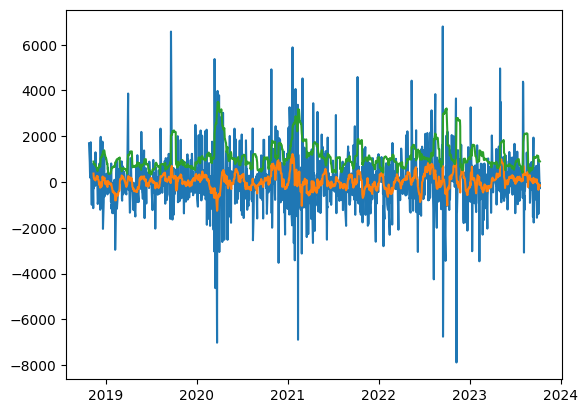

In [25]:
test_stationarity(dfclose.dropna(),"shiftDiff")

In [26]:
#thus we can see that stationarity has been achieved

In [ ]:
#Now since the p-value is less than 0.05, stationarity has been achieved

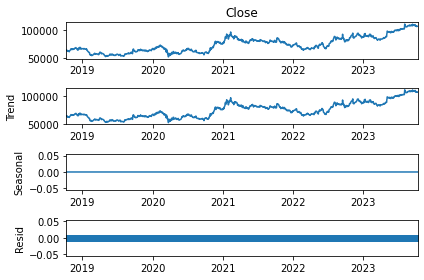

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed_data = seasonal_decompose(dfclose.Close, model ="additive", period = 1)
decomposed_data.plot();

In [ ]:
#we can see the trend, seasonality over here

C:\Users\atharv\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


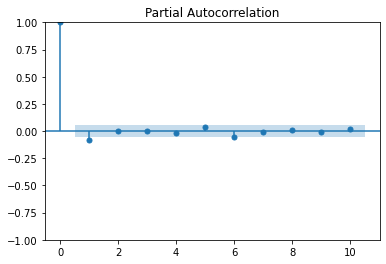

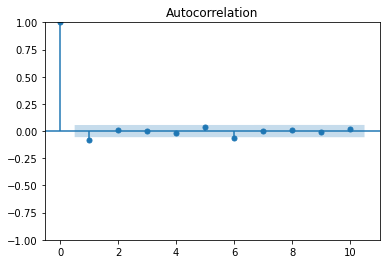

In [ ]:
plot_pacf(dfclose['shiftDiff'].dropna(),lags=10);
plot_acf(dfclose['shiftDiff'].dropna(),lags=10);

In [ ]:
#thus after plotting the pacf and acf values we can see that the p and q values both will be 1 and d will be 1

In [ ]:
#splitting data into train and test

In [27]:
train = dfclose[:round(len(dfclose.Close)*70/100)]

In [28]:
train = train.iloc[:,0:1]

In [29]:
train.head(1)

,Close
Date,
2018-10-10,63979.60156


In [30]:
train.tail(1)

,Close
Date,
2022-04-11,67765.64844


In [31]:
test = dfclose[round(len(dfclose.Close)*70/100):]

In [32]:
test = test.iloc[:,0:1]

In [33]:
test

,Close
Date,
2022-04-12,67585.70313
2022-04-13,67447.29688
2022-04-18,66944.95313
2022-04-19,66361.39844
2022-04-20,67670.39844
...,...
2023-10-04,106901.39840
2023-10-05,106770.50000
2023-10-06,107550.25000


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 371 entries, 2022-04-12 to 2023-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   371 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


In [35]:
test.tail(1)

,Close
Date,
2023-10-10,107204.1016


In [36]:
test.index[1]

Timestamp('2022-04-13 00:00:00')

In [37]:
order = (1, 1, 1)

model1 = ARIMA(train['Close'], order=order)
model1_fit1 = model1.fit()


c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [43]:
prediction1 = model1_fit1.predict(start = test.index[0], end = test.index[-1])

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [39]:
model1_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  865
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7342.129
Date:                Wed, 11 Oct 2023   AIC                          14690.257
Time:                        14:06:18   BIC                          14704.542
Sample:                             0   HQIC                         14695.725
                                - 865                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2832      0.316      0.897      0.370      -0.336       0.902
ma.L1         -0.3359      0.311     -1.080      0.280      -0.946       0.274
sigma2      1.406e+06   3.58e+04     39.220      0.000    1.34e+06    1.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.74   Jarque-Bera (JB):              1126.37
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
dftemp["arimapred"] = prediction

NameError: name 'prediction' is not defined

In [ ]:
plt.plot(dftemp.meantemp)
plt.plot(dftemp.arimapred)

In [ ]:
#thus we can see that arima predictions are not accurate

In [ ]:
#so we go for sarima model

In [ ]:
order = (2, 0, 1)
modeltemp1 = SARIMAX(train['meantemp'], order=order,seasonal_order=(2,0,1,12))
modeltemp1_fit = modeltemp1.fit()
predictionsar = modeltemp1_fit.predict(start=test.index[0], end=test.index[-1])

In [ ]:
dftemp["sarimapred"] = predictionsar

In [ ]:
plt.plot(dftemp.sarimapred)
plt.plot(dftemp.meantemp)
plt.plot(dftemp.arimapred)